In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

In [2]:

#import tensorflow as tf

#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#    raise SystemError('GPU device not found')
#print('GPU device:', device_name)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


ANN & Differential Evolution Algorithm - Full Notebook

### Imports & Setup

In [4]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

### Load Data

In [121]:
df_files = pd.read_csv("/content/Power.csv")

daymapper = {0.0: 'Mon', 1.0: 'Tue', 2.0: 'Wed', 3.0: 'Thu', 4.0: 'Fri', 5.0: 'Sat', 6.0: 'Sun'}
weekdaymapper = {0.0: 'Weekday', 1.0: 'Weekday', 2.0: 'Weekday', 3.0: 'Weekday', 4.0: 'Weekday',
                 5.0: 'Weekend', 6.0: 'Weekend'}
df_files['dayofweek'] = df_files['Day Of Week'].map(daymapper)
df_files['daytype'] = df_files['Day Of Week'].map(weekdaymapper)
df_files['Date'] = df_files['Date'].str.replace(' 00:00:00', '')

In [122]:

df_files.head()

,Date,Time,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand,dayofweek,daytype
0,2017-01-01,00:00:00,2017,1,1,4,1,53,0,0,1,0.8,0.1,95.0,7.0,12.9,99.17,17915,14403,Fri,Weekday
1,2017-01-01,01:00:00,2017,1,1,4,1,53,1,0,1,0.6,0.0,96.0,9.0,9.7,99.13,17915,13814,Fri,Weekday
2,2017-01-01,02:00:00,2017,1,1,4,1,53,2,0,1,0.7,0.0,95.0,13.0,9.7,99.13,17915,13366,Fri,Weekday
3,2017-01-01,03:00:00,2017,1,1,4,1,53,3,0,1,0.5,-0.5,93.0,9.0,16.1,99.18,17915,13120,Fri,Weekday
4,2017-01-01,04:00:00,2017,1,1,4,1,53,4,0,1,0.5,-0.6,92.0,9.0,16.1,99.17,17915,13075,Fri,Weekday


In [127]:
df_files.tail()
df_files.to_csv('Power Mitacs 2023.csv', index=False)

In [128]:
df_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57035 entries, 0 to 57034
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   57035 non-null  object 
 1   Time                   57035 non-null  object 
 2   Year                   57035 non-null  int64  
 3   Quarter                57035 non-null  int64  
 4   Month                  57035 non-null  int64  
 5   Day Of Week            57035 non-null  int64  
 6   Day Of Year            57035 non-null  int64  
 7   Week Of Year           57035 non-null  int64  
 8   Hour Of Day            57035 non-null  int64  
 9   Day Light Hours        57035 non-null  int64  
 10  Stat Holiday           57035 non-null  int64  
 11  Temperature            57035 non-null  float64
 12  Dew Point Temperature  57035 non-null  float64
 13  Relative Humidity      57035 non-null  float64
 14  Wind Speed             57035 non-null  float64
 15  Vi

In [129]:
for col in df_files.columns:
    print(col)

Date
Time
Year
Quarter
Month
Day Of Week
Day Of Year
Week Of Year
Hour Of Day
Day Light Hours
Stat Holiday
Temperature
Dew Point Temperature
Relative Humidity
Wind Speed
Visibility
Pressure
Daily Peak
Hourly Demand
dayofweek
daytype


In [130]:
df_files['Year'].value_counts()

2019    8784
2017    8760
2018    8760
2020    8760
2021    8760
2022    8760
2023    4451
Name: Year, dtype: int64

### Training Data for Every Hour - 2017 - 2022

In [132]:
pd.set_option('display.max_columns', 100)


# Convert the 'Date' column to datetime type
df_files['Date'] = pd.to_datetime(df_files['Date'], dayfirst=True, errors='coerce')

# Find the index of the row with the invalid date
invalid_date_index = df_files[df_files['Date'].isnull()].index

# Remove the row with the invalid date
df_files = df_files.drop(invalid_date_index)

# Filter rows based on the year range
df_filtered = df_files[df_files['Date'].dt.year.between(2017, 2022)]
df_filtered.head()

,Date,Time,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand,dayofweek,daytype
0,2017-01-01,00:00:00,2017,1,1,4,1,53,0,0,1,0.8,0.1,95.0,7.0,12.9,99.17,17915,14403,Fri,Weekday
1,2017-01-01,01:00:00,2017,1,1,4,1,53,1,0,1,0.6,0.0,96.0,9.0,9.7,99.13,17915,13814,Fri,Weekday
2,2017-01-01,02:00:00,2017,1,1,4,1,53,2,0,1,0.7,0.0,95.0,13.0,9.7,99.13,17915,13366,Fri,Weekday
3,2017-01-01,03:00:00,2017,1,1,4,1,53,3,0,1,0.5,-0.5,93.0,9.0,16.1,99.18,17915,13120,Fri,Weekday
4,2017-01-01,04:00:00,2017,1,1,4,1,53,4,0,1,0.5,-0.6,92.0,9.0,16.1,99.17,17915,13075,Fri,Weekday


In [12]:
df_filtered.tail()

,Date,Time,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand,dayofweek,daytype
52579,2022-12-31,19:00:00,2022,4,12,3,365,53,19,0,0,0.4,-4.4,70.0,18.0,24.1,99.85,17219,16486,Thu,Weekday
52580,2022-12-31,20:00:00,2022,4,12,3,365,53,20,0,0,0.2,-3.7,75.0,12.0,24.1,99.86,17219,15801,Thu,Weekday
52581,2022-12-31,21:00:00,2022,4,12,3,365,53,21,0,0,0.3,-4.4,71.0,24.0,24.1,99.80,17219,15048,Thu,Weekday
52582,2022-12-31,22:00:00,2022,4,12,3,365,53,22,0,0,0.2,-5.0,68.0,23.0,24.1,99.76,17219,14465,Thu,Weekday
52583,2022-12-31,23:00:00,2022,4,12,3,365,53,23,0,0,0.0,-5.2,68.0,25.0,24.1,99.70,17219,13892,Thu,Weekday


In [133]:
df_filtered.to_csv('hos.csv', index=False)

In [134]:
df_filtered.describe()

,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,2019.500000,2.509589,6.526027,3.000457,183.139726,26.592694,11.500000,0.511396,0.029680,9.148372,3.509632,69.932239,16.031868,21.716792,99.492283,18375.266667,16021.617713
std,1.707841,1.116778,3.447884,2.000361,105.406714,15.057669,6.922252,0.499875,0.169706,11.135520,10.512629,16.145456,9.416750,5.426164,0.746311,1980.749664,2428.980610
min,2017.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-25.400000,-31.400000,14.000000,0.000000,0.000000,96.220000,14101.000000,10539.000000
25%,2018.000000,2.000000,4.000000,1.000000,92.000000,14.000000,5.750000,0.000000,0.000000,0.900000,-4.200000,59.000000,9.000000,24.100000,99.040000,16942.000000,14222.000000
50%,2019.500000,3.000000,7.000000,3.000000,183.000000,27.000000,11.500000,1.000000,0.000000,9.600000,4.000000,71.000000,15.000000,24.100000,99.500000,18161.500000,16035.000000
75%,2021.000000,4.000000,10.000000,5.000000,274.000000,40.000000,17.250000,1.000000,0.000000,18.400000,12.200000,82.000000,21.000000,24.100000,99.970000,19794.000000,17605.000000
max,2022.000000,4.000000,12.000000,6.000000,366.000000,53.000000,23.000000,1.000000,1.000000,37.500000,24.600000,100.000000,85.000000,80.500000,102.210000,25450.000000,25450.000000


In [135]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [138]:
df_filtered.columns

Index(['Date', 'Time', 'Year', 'Quarter', 'Month', 'Day Of Week',
       'Day Of Year', 'Week Of Year', 'Hour Of Day', 'Day Light Hours',
       'Stat Holiday', 'Temperature', 'Dew Point Temperature',
       'Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure',
       'Daily Peak', 'Hourly Demand', 'dayofweek', 'daytype'],
      dtype='object')

In [139]:
features_train = df_filtered[['Quarter', 'Month', 'Day Of Week','Day Of Year', 'Week Of Year', 'Hour Of Day','Temperature', 'Dew Point Temperature','Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure','Daily Peak', 'Hourly Demand']]
features_train
scaler=StandardScaler()
Train=scaler.fit_transform(np.array(features_train))
Train

array([[-1.35174944e+00, -1.60274527e+00,  4.99686147e-01, ...,
        -4.31838425e-01, -2.32372144e-01, -6.66383710e-01],
       [-1.35174944e+00, -1.60274527e+00,  4.99686147e-01, ...,
        -4.85435879e-01, -2.32372144e-01, -9.08874573e-01],
       [-1.35174944e+00, -1.60274527e+00,  4.99686147e-01, ...,
        -4.85435879e-01, -2.32372144e-01, -1.09331584e+00],
       ...,
       [ 1.33457658e+00,  1.58764752e+00, -2.28271424e-04, ...,
         4.12321480e-01, -5.83757598e-01, -4.00837689e-01],
       [ 1.33457658e+00,  1.58764752e+00, -2.28271424e-04, ...,
         3.58724026e-01, -5.83757598e-01, -6.40858356e-01],
       [ 1.33457658e+00,  1.58764752e+00, -2.28271424e-04, ...,
         2.78327845e-01, -5.83757598e-01, -8.76762031e-01]])

In [140]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand
Quarter,1.00000,0.97136,-0.00297,0.96822,0.94276,0.00000,0.30358,0.34640,0.10891,-0.08284,0.04309,0.02772,-0.11688,-0.14665
Month,0.97136,1.00000,-0.00361,0.99650,0.96627,0.00000,0.29737,0.34408,0.11872,-0.08839,0.03801,0.04272,-0.12295,-0.15052
Day Of Week,-0.00297,-0.00361,1.00000,-0.00343,-0.00027,-0.00000,-0.01559,-0.01889,-0.00914,-0.00789,0.01303,0.04679,-0.32349,-0.22526
Day Of Year,0.96822,0.99650,-0.00343,1.00000,0.96736,0.00000,0.29427,0.34141,0.12015,-0.08790,0.03750,0.03985,-0.12087,-0.14854
Week Of Year,0.94276,0.96627,-0.00027,0.96736,1.00000,0.00000,0.29559,0.34511,0.12822,-0.08385,0.02955,0.02997,-0.12036,-0.14881
Hour Of Day,0.00000,0.00000,-0.00000,0.00000,0.00000,1.00000,0.09961,0.01391,-0.24911,0.13499,0.03009,-0.00854,-0.00000,0.45919
Temperature,0.30358,0.29737,-0.01559,0.29427,0.29559,0.09961,1.00000,0.93853,-0.19220,-0.13078,0.13418,-0.19999,-0.15925,-0.03755
Dew Point Temperature,0.34640,0.34408,-0.01889,0.34141,0.34511,0.01391,0.93853,1.00000,0.15280,-0.20908,-0.01891,-0.28030,-0.13305,-0.10862
Relative Humidity,0.10891,0.11872,-0.00914,0.12015,0.12822,-0.24911,-0.19220,0.15280,1.00000,-0.22812,-0.50982,-0.24615,0.06991,-0.20246
Wind Speed,-0.08284,-0.08839,-0.00789,-0.08790,-0.08385,0.13499,-0.13078,-0.20908,-0.22812,1.00000,0.08422,-0.27357,0.04371,0.19904


In [141]:
df_files.tail()

,Date,Time,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand,dayofweek,daytype
57030,2023-07-04,06:00:00,2023,3,7,0,186,27,6,1,0,16.9,10.1,64.0,7.0,24.1,99.68,19662,14544,Mon,Weekday
57031,2023-07-04,07:00:00,2023,3,7,0,186,27,7,1,0,20.0,8.2,46.0,1.0,24.1,99.67,19662,15478,Mon,Weekday
57032,2023-07-04,08:00:00,2023,3,7,0,186,27,8,1,0,22.5,7.7,38.0,3.0,24.1,99.67,19662,16190,Mon,Weekday
57033,2023-07-04,09:00:00,2023,3,7,0,186,27,9,1,0,24.6,8.8,36.0,10.0,24.1,99.61,19662,16643,Mon,Weekday
57034,2023-07-04,10:00:00,2023,3,7,0,186,27,10,1,0,25.4,8.2,33.0,14.0,24.1,99.55,19662,17039,Mon,Weekday


In [142]:
pd.set_option('display.max_columns', 100)

dftest = df_files[df_files['Date'].dt.year == 2023]
dftest.head()

,Date,Time,Year,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Day Light Hours,Stat Holiday,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand,dayofweek,daytype
52584,2023-01-01,00:00:00,2023,1,1,4,1,53,0,0,1,-0.3,-5.1,70.0,20.0,24.1,99.67,16979,13417,Fri,Weekday
52585,2023-01-01,01:00:00,2023,1,1,4,1,53,1,0,1,-0.3,-5.5,68.0,25.0,24.1,99.63,16979,12968,Fri,Weekday
52586,2023-01-01,02:00:00,2023,1,1,4,1,53,2,0,1,-0.4,-4.7,73.0,26.0,24.1,99.59,16979,12395,Fri,Weekday
52587,2023-01-01,03:00:00,2023,1,1,4,1,53,3,0,1,-0.4,-4.7,73.0,30.0,24.1,99.56,16979,12228,Fri,Weekday
52588,2023-01-01,04:00:00,2023,1,1,4,1,53,4,0,1,-0.4,-5.6,68.0,31.0,24.1,99.53,16979,12116,Fri,Weekday


In [143]:
features_test = dftest[['Quarter', 'Month', 'Day Of Week','Day Of Year', 'Week Of Year', 'Hour Of Day','Temperature', 'Dew Point Temperature','Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure','Daily Peak', 'Hourly Demand']]
Test = scaler.fit_transform(np.array(features_test))
Test

array([[-0.99165546, -1.46334143,  0.47966419, ...,  0.28879657,
        -0.33865982, -0.8903137 ],
       [-0.99165546, -1.46334143,  0.47966419, ...,  0.24044788,
        -0.33865982, -1.09899154],
       [-0.99165546, -1.46334143,  0.47966419, ...,  0.1920992 ,
        -0.33865982, -1.36529979],
       ...,
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.28879657,
         1.1802607 ,  0.39846949],
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.21627354,
         1.1802607 ,  0.60900638],
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.14375051,
         1.1802607 ,  0.79305187]])

In [144]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [145]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-1.35174944 -1.60274527  0.49968615 -1.72798725  1.75376131 -1.66132477
 -0.74971371 -0.32433982  1.55263493 -0.95913709 -1.6248819  -0.43183843
 -0.23237214]
[-1.35174944 -1.60274527  0.49968615 -1.72798725  1.75376131 -1.51686175
 -0.76767443 -0.33385228  1.61457245 -0.74674757 -2.2146227  -0.48543588
 -0.23237214]
[-1.35174944 -1.60274527  0.49968615 -1.72798725  1.75376131 -1.37239873
 -0.75869407 -0.33385228  1.55263493 -0.32196853 -2.2146227  -0.48543588
 -0.23237214]
[-1.35174944 -1.60274527  0.49968615 -1.72798725  1.75376131 -1.66132477
 -0.74971371 -0.32433982  1.55263493 -0.95913709 -1.6248819  -0.43183843
 -0.23237214 -1.35174944 -1.60274527  0.49968615 -1.72798725  1.75376131
 -1.51686175 -0.76767443 -0.33385228  1.61457245 -0.74674757 -2.2146227
 -0.48543588 -0.23237214 -1.35174944 -1.60274527  0.49968615 -1.72798725
  1.75376131 -1.37239873 -0.75869407 -0.33385228  1.55263493 -0.32196853
 -2.2146227  -0.48543588 -0.23237214]


In [146]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-0.66638371, -0.90887457, -1.09331584, -1.19459386, -1.21312032,
       -1.14766014, -1.02415036, -0.95663169, -0.90887457, -0.71990461,
       -0.47906055, -0.27032902])

In [147]:
print(Train.shape)
print(Train[2:].shape)
x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

(52560, 14)
(52558, 14)
x_train.shape: (52534, 42) x_test.shape: (500, 42)
y_train.shape: (52534, 24) y_test.shape: (500, 24)


In [148]:
import random
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn import metrics
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import differential_evolution
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

In [149]:
# Hyperparameter Lists #change up from int
batch_size_list = [8, 12, 16, 20, 24]
epoch_list = [200, 500, 1000]
learning_rate_list = [0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001]
print(batch_size_list)
print(epoch_list)
print(learning_rate_list)

[8, 12, 16, 20, 24]
[200, 500, 1000]
[0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005, 0.0001]


In [151]:
# Step 1: Initialize the Population
def initialize_population(population_size):
    population = []
    for _ in range(population_size):
        batch_size = np.random.choice(batch_size_list)
        num_epochs = np.random.choice(epoch_list)
        learning_rate = np.random.choice(learning_rate_list)
        population.append((batch_size, num_epochs, learning_rate))
    return population

In [152]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [153]:
# Step 2: Define Objective Function
def evaluate_fitness(hyperparameters):
    batch_size, epochs, learning_rate = hyperparameters

    # Create the ANN model
    with tf.device('/device:GPU:0'):
      model = Sequential()
      # Defining the input layer
      # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
      model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


      # Defining the  two hidden layers
      # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
      model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
      model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



      # Defining the output layer of the model
      model.add(Dense(24, kernel_initializer='normal',activation='linear'))

      # if op == "sgd":
      #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

      # elif op == "adamax":
      #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

      # elif op == "adam":
      #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

      # elif op == "adagrad":
      #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

      # else:
      #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

      # Compiling the model
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
      optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

      # Compiling the model
      model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])

      # Early_Stopping
      callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
                # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
                ]

      # Fitting the ANN to the Training set
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,validation_data=(x_val,y_val),callbacks=[callback],verbose=0)

      # Evaluate the model on the test set
      y_pred = model.predict(x_train)
      mape = mean_absolute_percentage_error(y_train, y_pred)

    return mape

#Implementation of the Meta-Heuristic Algorithm

In [154]:
# Step 3: Implement Differential Evolution Algorithm
def differential_evolution(population, max_generations, mutation_factor, crossover_prob):
    population_size = len(population)

    for generation in range(max_generations):
        for i in range(population_size):
            target_vector = population[i]

            # Step 3a: Mutation
            a, b, c = np.random.choice(population_size, 3, replace=False)
            #mutant_vector = (
            #    population[a][0] + mutation_factor * (population[b][0] - population[c][0]),
            #    population[a][1] + mutation_factor * (population[b][1] - population[c][1]),
            #    population[a][2] + mutation_factor * (population[b][2] - population[c][2])
            #)
            mutant_vector = []
            if population[a][0] + mutation_factor * (population[b][0] - population[c][0]) < 8:
                mutant_vector.append(8)
            elif population[a][0] + mutation_factor * (population[b][0] - population[c][0]) > 24:
                mutant_vector.append(24)
            else:
                mutant_vector.append(population[a][0] + mutation_factor * (population[b][0] - population[c][0]))

            if population[a][1] + mutation_factor * (population[b][1] - population[c][1]) < 1000:
                mutant_vector.append(1000)
            elif population[a][1] + mutation_factor * (population[b][1] - population[c][1]) > 1000:
                mutant_vector.append(1000)
            else:
                mutant_vector.append(population[a][1] + mutation_factor * (population[b][1] - population[c][1]))

            if population[a][2] + mutation_factor * (population[b][2] - population[c][2]) < 0.0001:
                mutant_vector.append(0.0001)
            elif population[a][2] + mutation_factor * (population[b][2] - population[c][2]) > 0.5:
                mutant_vector.append(0.5)
            else:
                mutant_vector.append(population[a][2] + mutation_factor * (population[b][2] - population[c][2]))

            mutant_vector = tuple(mutant_vector)

            # Step 3b: Recombination
            trial_vector = []
            for j in range(len(target_vector)):
                if np.random.rand() <= crossover_prob:
                    trial_vector.append(mutant_vector[j])
                else:
                    trial_vector.append(target_vector[j])

            trial_vector[0] = np.int64(trial_vector[0])
            trial_vector[1] = np.int64(trial_vector[1])
            trial_vector[2] = np.float64(trial_vector[2])
            trial_vector = tuple(trial_vector)

            #Step 3c: Selection
            target_fitness = evaluate_fitness(target_vector)
            trial_fitness = evaluate_fitness(trial_vector)

            mape = min(target_fitness, trial_fitness)
            if trial_fitness < target_fitness:
                population[i] = trial_vector

            print(generation+1, 'Parameters:','batch_size:', population[i][0], 'epochs:', population[i][1],"lr:", population[i][2], 'MAPE:', mape)

    # Step 4: Obtain the Best Solution
    best_solution = min(population, key=evaluate_fitness)
    return best_solution

In [155]:
# Step 5: Run Differential Evolution
population_size = 10
max_generations = 10
mutation_factor = 0.8
crossover_prob = 0.9

In [156]:
# Initialize the population
population = initialize_population(population_size)
print(population)

[(12, 200, 0.075), (16, 1000, 0.05), (24, 1000, 0.05), (16, 500, 0.5), (24, 500, 0.0075), (24, 1000, 0.05), (20, 200, 0.25), (20, 200, 0.0075), (12, 1000, 0.0001), (16, 1000, 0.1)]


In [ ]:
# Run Differential Evolution
best_hyperparameters = differential_evolution(population, max_generations, mutation_factor, crossover_prob)

1232/1232 [==============================] - 2s 1ms/step
1 Parameters: batch_size: 16 epochs: 1000 lr: 0.0001 MAPE: 1.098773132916323
1232/1232 [==============================] - 2s 2ms/step
1 Parameters: batch_size: 19 epochs: 1000 lr: 0.040100000000000004 MAPE: 1.0267930311722868
1232/1232 [==============================] - 2s 1ms/step
1 Parameters: batch_size: 20 epochs: 1000 lr: 0.0025 MAPE: 1.1132469950276649
1232/1232 [==============================] - 2s 2ms/step
1 Parameters: batch_size: 20 epochs: 200 lr: 0.075 MAPE: 1.1098840185843881
1232/1232 [==============================] - 2s 2ms/step
1 Parameters: batch_size: 20 epochs: 500 lr: 0.001 MAPE: 1.0923003244492293
1232/1232 [==============================] - 2s 2ms/step
1 Parameters: batch_size: 15 epochs: 1000 lr: 0.0001 MAPE: 1.1101620835836954
1232/1232 [==============================] - 2s 1ms/step
1 Parameters: batch_size: 16 epochs: 500 lr: 0.0005 MAPE: 1.0960731651470632
1232/1232 [==============================] - 2s

In [157]:
def ANNmodel(param):
  batch_sz, ep, lr  = param
  model = Sequential()
  # Defining the input layer
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

  # Defining the  two hidden layers
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))

  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # Compiling the model
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['accuracy'])

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=0)

  return model

In [173]:
param = [19, 1000 ,0.040100000000000004]
model = ANNmodel(param)
print(model)

In [174]:
y_test[:, 1].shape

(500,)

16/16 [==============================] - 0s 2ms/step


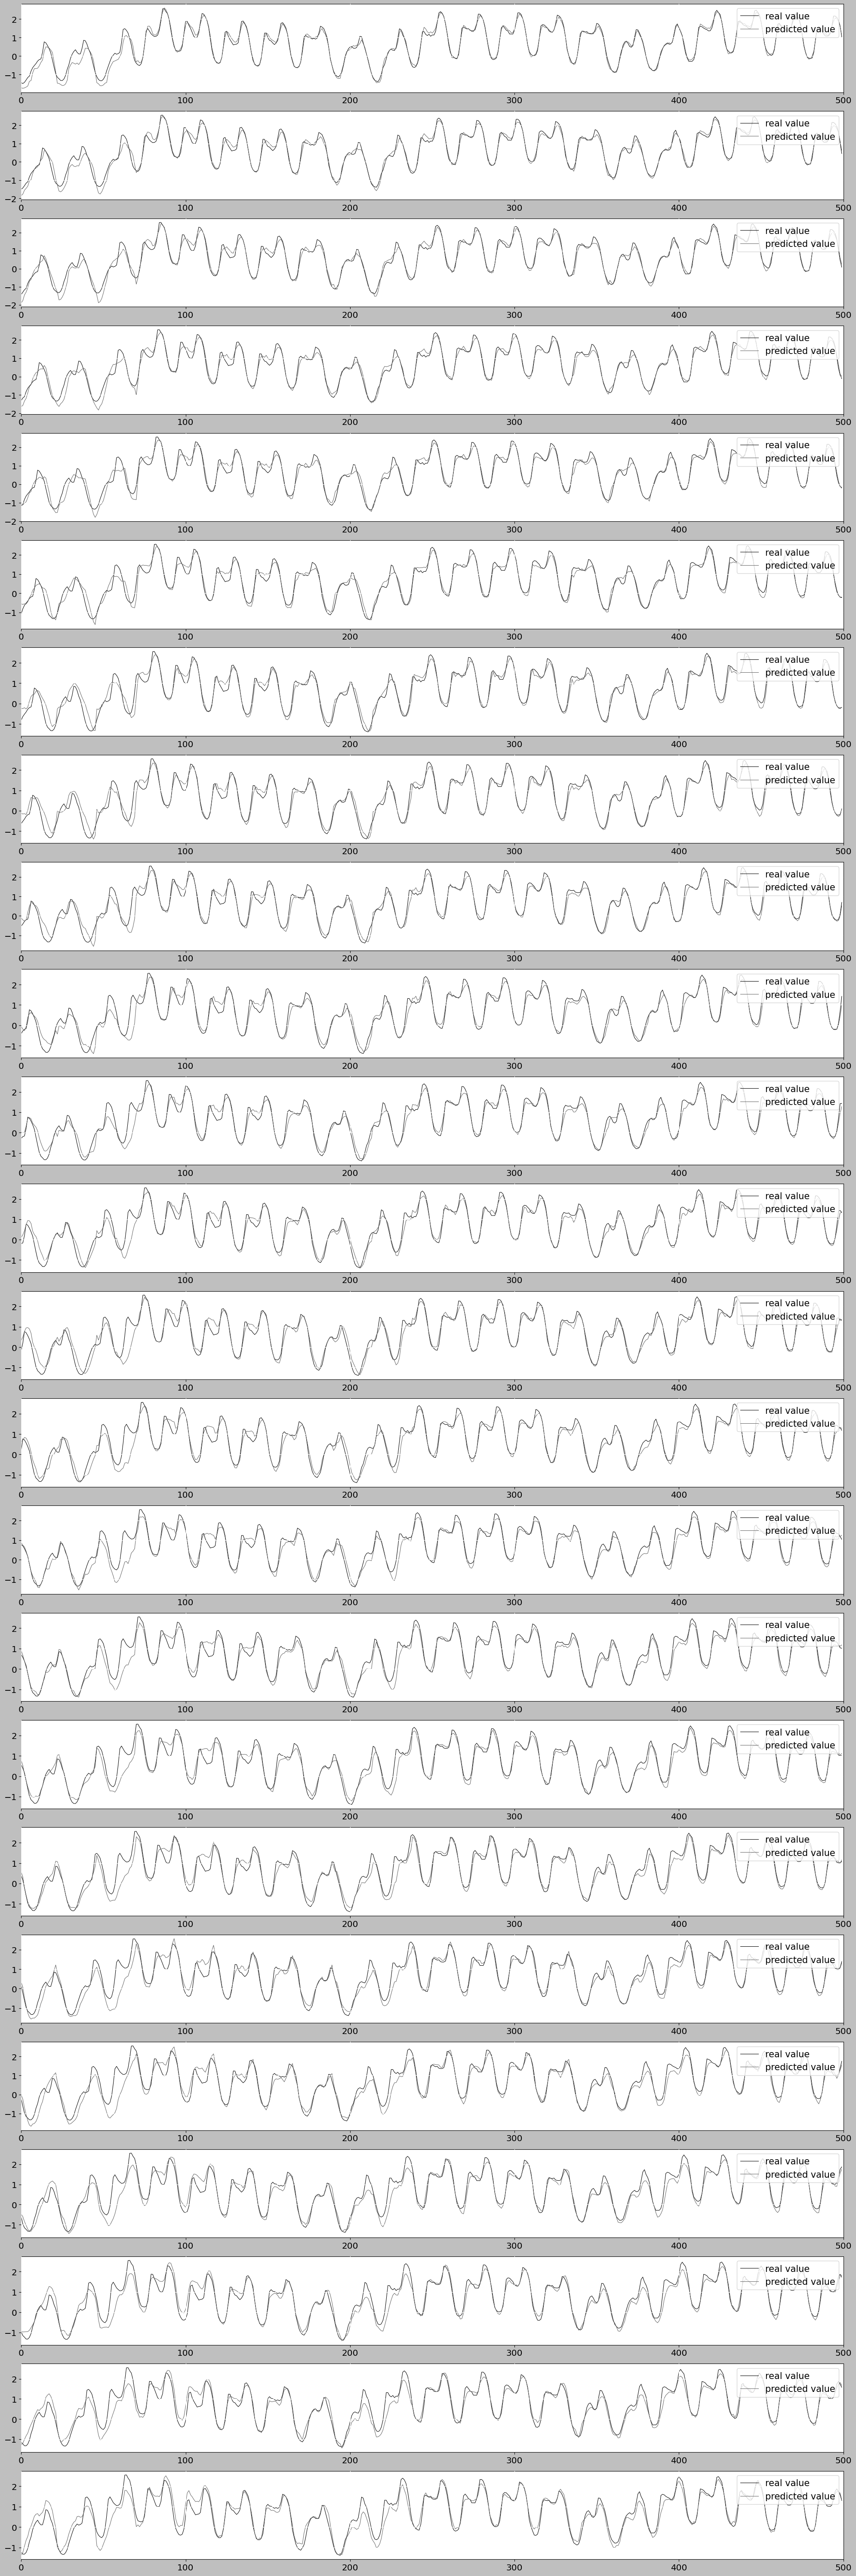

In [175]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(x_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

# PREDICTION FOR WHOLE YEAR

In [176]:
pd.set_option('display.max_columns', 100)
dfpredict_data = df_files[df_files['Date'].dt.year == 2023]
predict_data = dfpredict_data[['Quarter', 'Month', 'Day Of Week','Day Of Year', 'Week Of Year', 'Hour Of Day','Temperature', 'Dew Point Temperature','Relative Humidity', 'Wind Speed', 'Visibility', 'Pressure','Daily Peak', 'Hourly Demand']]
predict_data

,Quarter,Month,Day Of Week,Day Of Year,Week Of Year,Hour Of Day,Temperature,Dew Point Temperature,Relative Humidity,Wind Speed,Visibility,Pressure,Daily Peak,Hourly Demand
52584,1,1,4,1,53,0,-0.3,-5.1,70.0,20.0,24.1,99.67,16979,13417
52585,1,1,4,1,53,1,-0.3,-5.5,68.0,25.0,24.1,99.63,16979,12968
52586,1,1,4,1,53,2,-0.4,-4.7,73.0,26.0,24.1,99.59,16979,12395
52587,1,1,4,1,53,3,-0.4,-4.7,73.0,30.0,24.1,99.56,16979,12228
52588,1,1,4,1,53,4,-0.4,-5.6,68.0,31.0,24.1,99.53,16979,12116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57030,3,7,0,186,27,6,16.9,10.1,64.0,7.0,24.1,99.68,19662,14544
57031,3,7,0,186,27,7,20.0,8.2,46.0,1.0,24.1,99.67,19662,15478
57032,3,7,0,186,27,8,22.5,7.7,38.0,3.0,24.1,99.67,19662,16190
57033,3,7,0,186,27,9,24.6,8.8,36.0,10.0,24.1,99.61,19662,16643


In [177]:
scaler=StandardScaler()
predict=scaler.fit_transform(np.array(predict_data))
predict

array([[-0.99165546, -1.46334143,  0.47966419, ...,  0.28879657,
        -0.33865982, -0.8903137 ],
       [-0.99165546, -1.46334143,  0.47966419, ...,  0.24044788,
        -0.33865982, -1.09899154],
       [-0.99165546, -1.46334143,  0.47966419, ...,  0.1920992 ,
        -0.33865982, -1.36529979],
       ...,
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.28879657,
         1.1802607 ,  0.39846949],
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.21627354,
         1.1802607 ,  0.60900638],
       [ 2.74456474,  1.94803957, -1.52172447, ...,  0.14375051,
         1.1802607 ,  0.79305187]])

In [178]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (4401, 42)
yp.shape: (4401, 24)


In [179]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

138/138 [==============================] - 0s 2ms/step


In [180]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 2.4901359994805397
(4401, 24)
(4401, 24)
Worst MAPE: 207.15079585916496
Best MAPE: 0.058722529854597055


#Visualisation

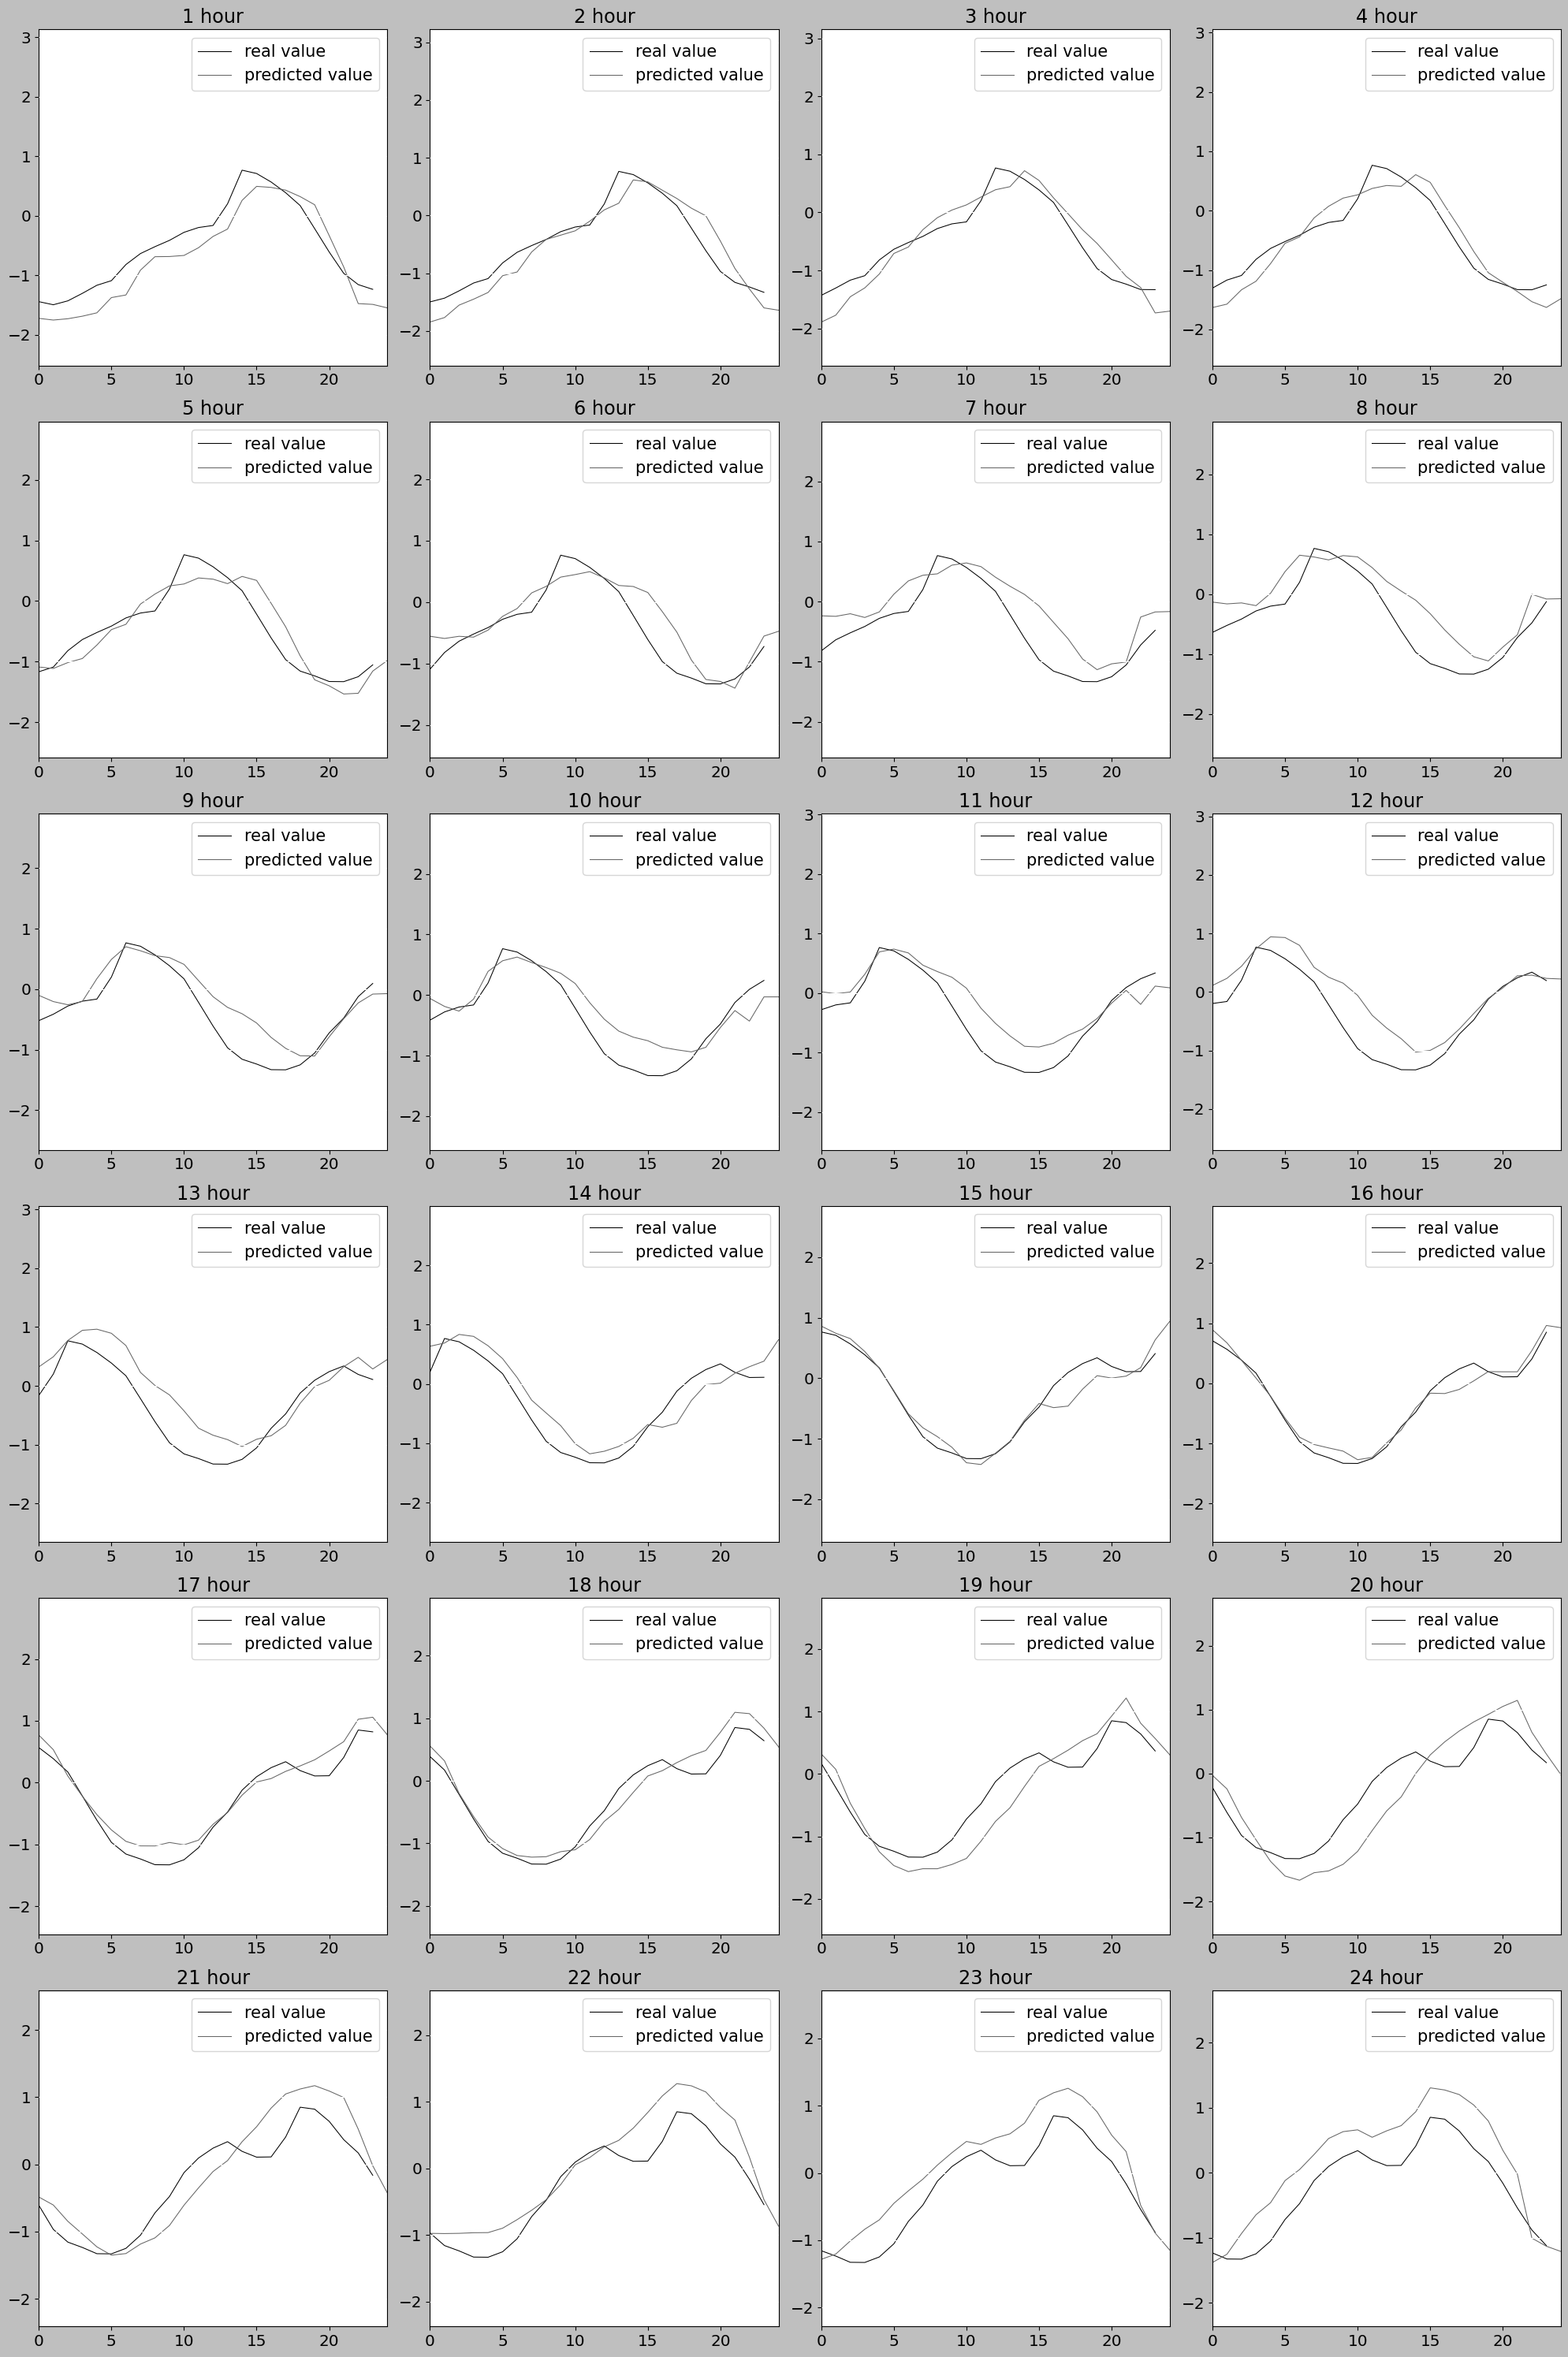

In [181]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [182]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])

def aggregate_plot(y_actual, y_pred):
    y_mean_pred = []
    for j in range(23, -1, -1):
        sum = 0
        for i in range(0, 24):
            if j - i >= 0:
                sum += y_pred[i][j - i]
        y_mean_pred.append(sum / (j + 1))
    y_mean_pred = list(reversed(y_mean_pred))
    df_predict_aggregate['prediction_agg'] = y_mean_pred
    df_predict_aggregate['actual'] = y_actual

    mape = mean_absolute_percentage_error(yp, y_prediction)
    print("MAPE:", mape)

    # Find the position and value of the highest predicted value
    max_value = max(y_mean_pred)
    max_index = y_mean_pred.index(max_value)
    # print("Highest Predicted Value:", max_value)
    print("Position of Highest Predicted Value:", max_index)

    plt.plot(y_actual, marker='*', color='blue')
    plt.plot(y_mean_pred, marker='+', color='red')
    plt.legend(('Real Value', 'Predicted Value'), loc='upper right', fontsize='15')
    plt.show()





In [183]:
df_predict_aggregate

,prediction_agg,actual


MAPE: 2.4901359994805397
Position of Highest Predicted Value: 15


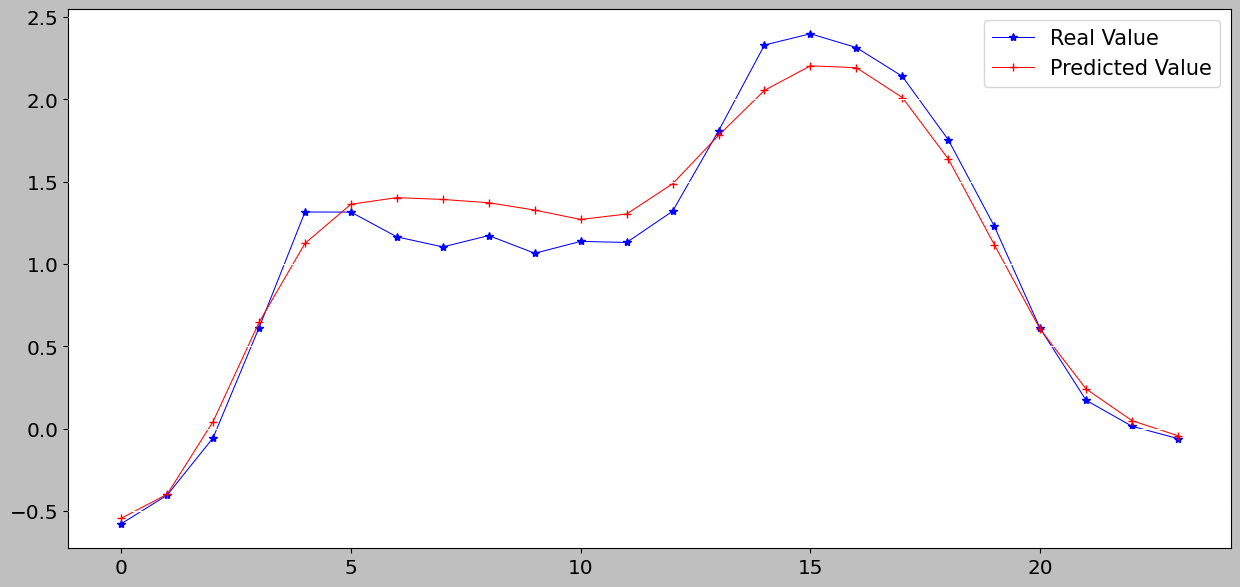

In [184]:
aggregate_plot(yp[240], y_prediction[240:264])